# Deep Learning with Python - Chapter 3

## Example 3 - Predicting House Prices
Will use `keras`' built-in dataset about houses in Boston suburbs from the mid 1970s to predict the price of a house for a given set of features. This is a **regression** problem: instead of predicting whether a given sample with a given set of features belongs to a category or class, we are predicting a **continuous** value. The regression problem therefore involves mapping a set of features (numerical/categorical) to a continuous numerical value.

## Loading Data

In [3]:
# import libs
import tensorflow, keras

In [4]:
# Load `boston_housing` dataset that comes prepackaged with Keras
from keras.datasets import boston_housing

# Train/test split - because regression, the dependent variables are `targets` and not `labels`
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [6]:
# Examine training and test data
print("Training Data shape = " + str(train_data.shape))
print("Test Data shape = " + str(test_data.shape))

Training Data shape = (404, 13)
Test Data shape = (102, 13)


Compared to `MNIST`, `IMDb`, and `Reuters`, this is a very small dataset with very few training examples with only 404 training examples and 102 test examples, each with 13 different features. This may affect the accuracy of our predictions, as models trained on smaller datasets are more susceptible to overfitting or underfitting.

In [11]:
# Examine targets
print(train_targets[:10]) # first ten median prices in 1000s of dollars

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


## Data Preprocessing
**Feature Normalization** is the process of modifying the features of the input data so that all features occupy roughly the same range of values. This prevents one or more features with larger values from skewing the results of the model. This also makes training more efficient/easier.

Feature normalization involves modifying each value in a column as follows
$$ x_{ij}^{'} = \frac{x_{ij} - \mu_{j}}{\sigma{_j}}$$
where 
- $x_{ij}^{'}$ is the normalized value of the $j^{th}$ feature for the $i^{th}$ sample/observation.
- $x_{ij}$ is the original value of the $j^{th}$ feature for the $i^{th}$ sample/observation.
- $\mu_{j}$ is the mean value of the $j^{th}$ feature across all observations in the dataset.
- $\sigma_{j}$ is the standard deviation of the $j^{th}$ feature across all observations in the dataset.


In [16]:
# Feature normalization
mean = train_data.mean(axis=0) # mean of each feature in the matrix of training data. Mean calculated across rows (0 axis)
std = train_data.std(axis=0)

train_data -= mean # subtracting each value in a column by its mean - broadcasting
test_data /= std   # dividing each value in a column by its standard deviation

# Do not compute new mean and std for test data. 
test_data -= mean
test_data /= std

The mean and standard deviation must be computed using only the training data. **Never** use any value computed from the test data in any part of the workflow, because our model should be completely independent of the test data. The test data is **unseen** data i.e. data the model doesn't even know exists. If the data doesn't exist (as far as the model is concerned), we obviously can't use any values derived from it in the training process.

## Building Network
- Because the dataset is very small, we're using a very simple ANN with only one hidden layer and 64 nodes per layer. 
- The output layer has a single node with no activation function. It is a linear layer.
- Specifying an activation function for the final layer would constrain the range its output can take. We don't want this, as the price prediction can take any value.
- This is a common set up for single value regression.

In [45]:
from keras import models, layers

# Define function to build model since this will be done several times
def build_model():
    """Builds a three layer ANN with 64 ReLU units in IP/Hidden and 1 unit in OP."""
    # Instantiate
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # haven't specified an activation function - linear layer
    
    # Compile - Mean Squared Error loss function with Mean Absolute Error as a measure of accuracy
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    # Return the model
    return model

## K-Fold Cross Validation
- When the training data is small, validation set will also be small. This means the validation scores will have high variance i.e. if the validation scores would change substantially based on which random subset of samples we used for validation.
- This would prevent us from accurately assessing the performance of our model.
- The solution is to divide the entire training data into `k` folds (`k` is usually 4 or 5, but can also be 10). 
- For each fold, the model is trained on `k-1` partitions and tested on the remaining partition.
- This is repeated `k` times, with a different subset of the partitions being used for training and testing.
- In this way, a new model is created for each fold and trained with all possible `k-1` combinations of folds and is used to predict on every possible fold.
- The validation score for the model is the average of th `k` validation scores obtained from each model.

In [48]:
import numpy as np

# Number of folds
k = 4

num_val_samples = len(train_data) // 4 # divide the training data into 4 sections - INTEGER DIVISION!
num_epochs = 100                       # will train each model for 100 iterations
all_scores = []                        # list to record mae for each model 

for i in range(k):
    print("Processing fold #", i)
    
    # Get a different subset of the training data as validation set each time
    val_data = train_data[(i * num_val_samples) : ((i + 1) * num_val_samples)]
    val_targets = train_targets[(i * num_val_samples) : ((i + 1) * num_val_samples)]
    
    # All the remaining data is partial train - concatenate because slices separated by validation block
    partial_train_data = np.concatenate([train_data[ : (i * num_val_samples)], 
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[ : (i * num_val_samples)], 
                                         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    # Fit a model to this particular permutation of folds
    model = build_model()

    # Small batch size because very small dataset, so can process it all in one go. Verbose 0 so doesn't log training
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # New validation set is test set for each iteration
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # Append only the mean absolute error to the list
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


The processing took a long time because we were training 4 different models with 4 different subsets of the dataset as training/test set, each for 100 epochs. So while k-fold cross validation does improve accuracy of model performance metrics, it does have a computational cost.

The mean absolute errors for models trained with and validated against different subsets of the dataset do indeed have different values. However, their average value of 2.81014 is a better, more reliable metric for the error in our model's predictions than any single score. We can reliably/confidently say that our predictions for the price of a house will not be off by more than USD 2810.

In [54]:
# Echo all mean absolute errors
print(all_scores)

# The final mean absolute error will be the average error for all folds
print("Mean Error = " + str(np.mean(all_scores)))

[2.344562056041, 2.8534467739633995, 2.9023807804183206, 3.140199511358053]
Mean Error = 2.8101472804451935


## Training for 500 Epochs, Storing History

In [59]:
# Number of folds
k = 4

num_val_samples = len(train_data) // 4 # divide the training data into 4 sections - INTEGER DIVISION!
num_epochs = 500                       # will train each model for 100 iterations
all_mae_histories = []

for i in range(k):
    print("Processing fold #", i)
    
    # Get a different subset of the training data as validation set each time
    val_data = train_data[(i * num_val_samples) : ((i + 1) * num_val_samples)]
    val_targets = train_targets[(i * num_val_samples) : ((i + 1) * num_val_samples)]
    
    # All the remaining data is partial train - concatenate because slices separated by validation block
    partial_train_data = np.concatenate([train_data[ : (i * num_val_samples)], 
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[ : (i * num_val_samples)], 
                                         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    # Fit a model to this particular permutation of folds
    model = build_model()

    # Small batch size because very small dataset, so can process it all in one go. Verbose 0 so doesn't log training
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0,
                       validation_data=(val_data, val_targets))
    
    # Record the validation set MAE for each model
    mae_history = history.history['val_mean_absolute_error']
    
    # Append this to the list of all MAE histories
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


This took longer than any other model I've trained so far hahahahahahaahha.

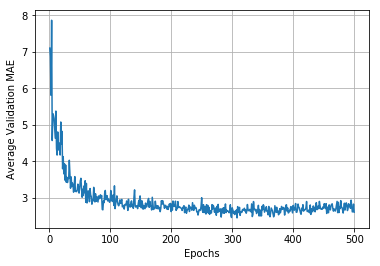

<Figure size 432x288 with 0 Axes>

In [65]:
# We can now plot the average MAE scores across all epochs
average_mae_history = [
    # find the mean validat mae for each epoch
    np.mean([x[i] for x in all_mae_histories]) for 
    i in range(num_epochs)]

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 4));
plt.plot(range(1, len(average_mae_history) + 1), 
        average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Average Validation MAE')
plt.grid(True); plt.show(); plt.tight_layout()

## Plotting a Smoother Avg Validation MAE

In [66]:
# Function to compute exponential moving average to smoothen our curve
def smooth_curve(points, factor=0.9):
    # a new list to keep track of moving averages
    smoothed_points = []
    
    # for every point in the original data
    for point in points:
        # if previous smoothed values exist
        if smoothed_points:
            # compute a new value for the current point using prev values
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        # if first point i.e no prev moving averages
        else:
            smoothed_points.append(point)
    
    # return the data vector of moving averages
    return smoothed_points

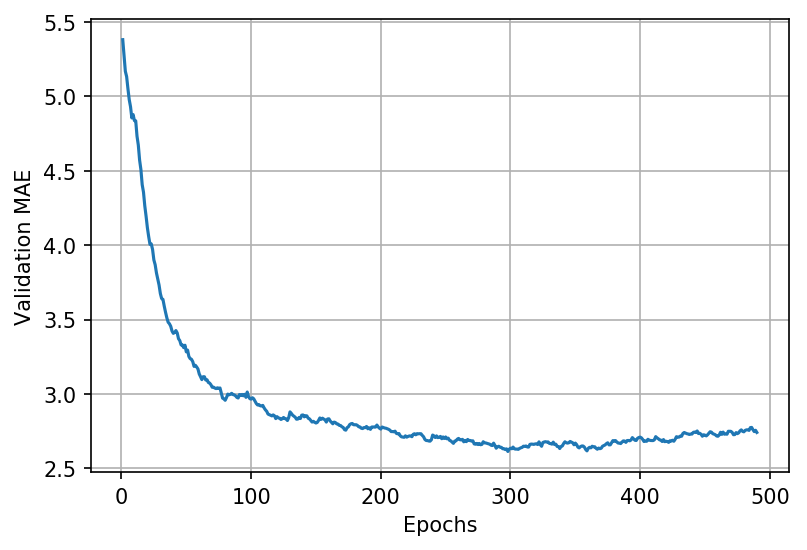

In [76]:
# Plot moving average of the data - drop first 10 values because outliers
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(range(1, len(smooth_mae_history) + 1), 
        smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.show()

Book's plot says the model stops improving after the 80th epoch, but from my graph it looks like the model stops improving after 300 epochs. Will train with both 80 and 300 epochs and compare result.

## Training Model with 80 Epochs

In [70]:
model = build_model()
model.fit(train_data, train_targets, 
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


## Training the Model with 300 Epochs

In [72]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=300, batch_size=64, verbose=0)
test_mse_score_300, test_mae_score_300 = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [73]:
# Comparing Results
print("80 Epochs:\t" + str(test_mae_score))
print("300 Epochs:\t" + str(test_mae_score_300))

80 Epochs:	44.94300400977041
300 Epochs:	35.87194008920707


Something's wrong. The MAE is too high. We can't be off by 35k.

## Trying Again

In [83]:
import numpy as np
k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [85]:
all_scores

[2.6960710381517314, 2.9547874455404752, 3.0187529478922928, 2.981301413904322]

In [86]:
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
                                          train_data[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
                                             train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) 
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [91]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [92]:
average_mae_history[:20]

[8.232049658747004,
 7.389010690226414,
 6.571753953943158,
 5.604526208178832,
 6.108912085542585,
 5.326330323030453,
 5.7083296232884475,
 5.720962586969432,
 4.990702134547847,
 4.280910037531711,
 4.257682134609411,
 4.745449365955768,
 5.3630412722578145,
 4.988739483427294,
 4.028758916524377,
 4.258589853154551,
 3.9705450936119155,
 5.227402147680226,
 4.249959716702452,
 4.5541198831973695]

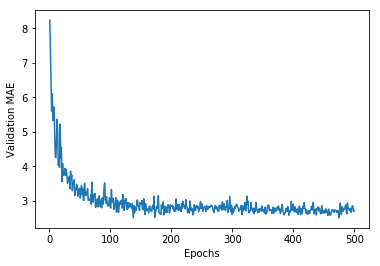

In [88]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Text(0,0.5,'Validation MAE')

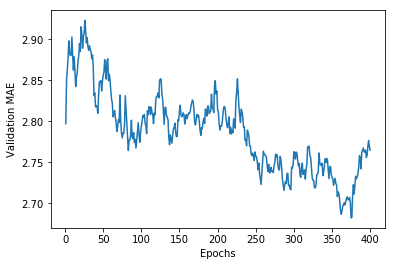

In [95]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[100:])
plt.figure();
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [97]:
model = build_model()
model.fit(train_data, train_targets, epochs=300, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


98.78580055984796

In [98]:
print(test_mae_score)

98.78580055984796


¯\\_ _(ツ)_ _/¯